# Name: Vakkala Yaswanth
# Reg no: 122010318051

# 1. Importing Required Packages

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, BatchNormalization, AveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import os

# 2. Loading and Preprocessing the data

In [2]:
print(os.listdir('../data/breast_cancer'))
print(os.listdir('../data/breast_cancer/train'))
print(os.listdir('../data/breast_cancer/test'))

['test', 'train']
['benign', 'malignant']
['benign', 'malignant']


In [3]:
root_dir = '../data/breast_cancer'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')
train_benign_dir = os.path.join(train_dir,'benign')
train_malignant_dir = os.path.join(train_dir, 'malignant')
test_benign_dir = os.path.join(test_dir, 'benign')
test_malignant_dir = os.path.join(test_dir, 'malignant')

In [4]:
print('No of benign training images are',len(os.listdir(train_benign_dir)))
print('No of malignant training images are',len(os.listdir(train_malignant_dir)))
print('No of benign testing images are',len(os.listdir(test_benign_dir)))
print('No of malignant testing images are',len(os.listdir(test_malignant_dir)))

No of benign training images are 4074
No of malignant training images are 4042
No of benign testing images are 500
No of malignant testing images are 400


### • Conclusion from above analysis: 
Here both the classes of the training data have almost same ratio in total training data. This means the chance of bias towards a particular class after training by the model is very low.

### • Visualizing the Images

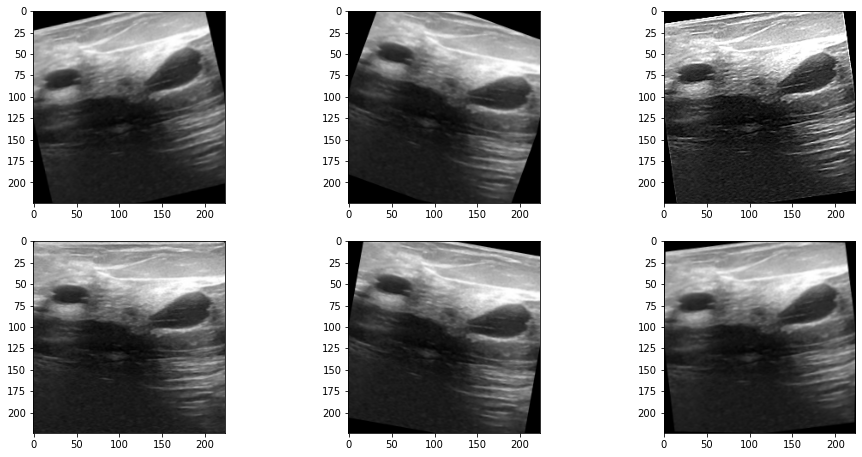

In [5]:
benign_train_images = os.listdir(train_benign_dir)
plt.figure(figsize=(16, 12))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(train_benign_dir, benign_train_images[i]))
    plt.imshow(img, cmap='gray')
plt.show()

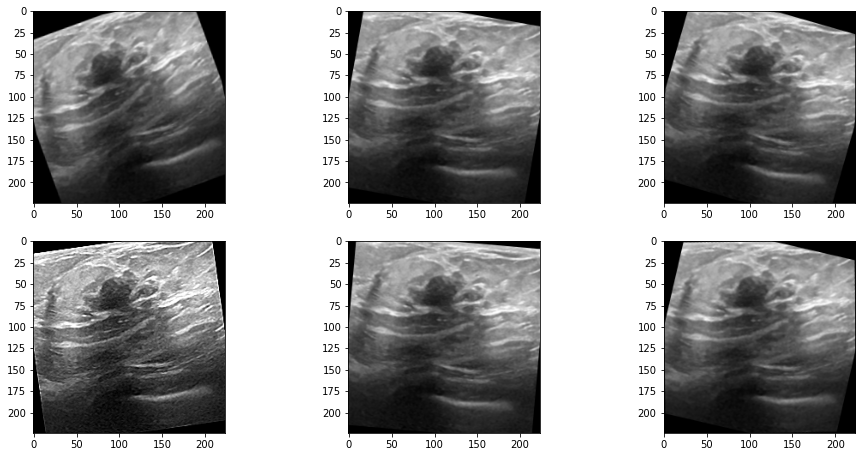

In [6]:
malignant_train_images = os.listdir(train_malignant_dir)
plt.figure(figsize=(16, 12))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(train_malignant_dir, malignant_train_images[i]))
    plt.imshow(img, cmap='gray')
plt.show()

### • Conclusion from above Images and whole dataset: 
All the images in the dataset are of 224 x 244 pixels in size. The given dataset is augmented as we can see the images are of different zoom ratios, rotations, etc. This means we can't augment this dataset further, but the current 8000+ images should be sufficient to train a good model. Also the clarity of these ultrasonic scans is quite poor. All these factors make the trained model achieve extremely high accuracies very difficult.

### • Importing the data
Here I imported the data with some modifications. At first using keras ImageDataGenerator I set the validation split to 10% of the training data and also normalize the pixel values of the images from 0 to 255 to 0 to 1. This normalization makes calculations simpler while training the model. 

Then I used flow_from_directory method to import data and also resize all images to 150 x 150 pixels for faster training and convergence. Instead of feeding the entire dataset at once, I used a batch size of 32. I set the class mode to binary as this is a binary classification problem and numerical labels will be automatically assigned by keras based on this

In [7]:
igen_train = ImageDataGenerator(rescale = 1/255, validation_split=0.1)
igen_validation = ImageDataGenerator(rescale = 1/255)
igen_test = ImageDataGenerator(rescale = 1/255)

In [8]:
train = igen_train.flow_from_directory(train_dir, 
                                            target_size=(150, 150),
                                            subset = 'training',
                                            batch_size = 32,
                                            class_mode = 'binary')
validation = igen_train.flow_from_directory(train_dir, 
                                            target_size=(150, 150),
                                            subset = 'validation',
                                            batch_size = 32,
                                            class_mode = 'binary')
test = igen_test.flow_from_directory(test_dir, 
                                            target_size=(150, 150),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 7305 images belonging to 2 classes.
Found 811 images belonging to 2 classes.
Found 900 images belonging to 2 classes.


In [9]:
train.class_indices

{'benign': 0, 'malignant': 1}

In [10]:
train.image_shape

(150, 150, 3)

# Model - 1

# 3. Building Model - 1 architecture

Here I used 2 convultinal layers first to extract the features from the images. I used relu activation function as I don't need negative features for this use case `mmand 'same' padding to not miss even the border features. Maxpooling is used here to extract most important features. Dropout layer is used to reduce overfitting. After convolution layers I used 1 hidden layer with relu activation and 1 output layer with sigmoid activation.

In [11]:
model = Sequential()

model.add(Conv2D(32, (5,5), padding='SAME', activation='relu', input_shape=(150,150,3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (5,5), padding='SAME', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 64)        0

I have used Adam optimizer as it has the advantages of both momentum and RMS loss functions. I used binary_crossentropy loss function which is best suited for cnn related binary classification problems. Here the accuracy is the metric I am tracking. The no of epochs are set to 12.

In [12]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# 4. Training Model - 1

In [13]:
trained_model = model.fit(train, epochs = 12, validation_data = validation)

Epoch 1/12
229/229 [==============================] - 211s 778ms/step - loss: 0.6251 - accuracy: 0.6747 - val_loss: 0.6347 - val_accuracy: 0.6375
Epoch 2/12
229/229 [==============================] - 42s 184ms/step - loss: 0.4056 - accuracy: 0.8153 - val_loss: 0.6066 - val_accuracy: 0.6486
Epoch 3/12
229/229 [==============================] - 41s 181ms/step - loss: 0.2941 - accuracy: 0.8695 - val_loss: 0.5551 - val_accuracy: 0.6831
Epoch 4/12
229/229 [==============================] - 43s 185ms/step - loss: 0.2154 - accuracy: 0.9125 - val_loss: 0.7379 - val_accuracy: 0.6831
Epoch 5/12
229/229 [==============================] - 48s 207ms/step - loss: 0.1408 - accuracy: 0.9441 - val_loss: 1.0222 - val_accuracy: 0.6510
Epoch 6/12
229/229 [==============================] - 52s 226ms/step - loss: 0.0990 - accuracy: 0.9628 - val_loss: 1.0077 - val_accuracy: 0.6769
Epoch 7/12
229/229 [==============================] - 51s 223ms/step - loss: 0.0750 - accuracy: 0.9707 - val_loss: 1.1106 - val_a

# 5. Testing Model - 1

In [16]:
loss, acc = model.evaluate(test)
print(loss)
print(acc*100, "%", sep="")

29/29 [==============================] - 13s 452ms/step - loss: 1.4541 - accuracy: 0.8333
1.4540605545043945
83.33333134651184%


### Conclusion from the above model - 1:
The above model - 1 overfitted as there is huge gap between training and testign accuracy. The testing accuracy is 83.33 % which is not bad and loss is 1.45. This can be improved a lot but not by more epochs as the model is overfitting.

# Model - 2

### • Importing the data
The changes here are I am setting 20% of the training data as validation data.

In [19]:
igen_train = ImageDataGenerator(rescale = 1/255, validation_split=0.2)
igen_validation = ImageDataGenerator(rescale = 1/255)
igen_test = ImageDataGenerator(rescale = 1/255)

In [20]:
train = igen_train.flow_from_directory(train_dir, 
                                            target_size=(150, 150),
                                            subset = 'training',
                                            batch_size = 32,
                                            class_mode = 'binary')
validation = igen_train.flow_from_directory(train_dir, 
                                            target_size=(150, 150),
                                            subset = 'validation',
                                            batch_size = 32,
                                            class_mode = 'binary')
test = igen_test.flow_from_directory(test_dir, 
                                            target_size=(150, 150),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 6494 images belonging to 2 classes.
Found 1622 images belonging to 2 classes.
Found 900 images belonging to 2 classes.


# 3. Building Model - 2 architecture

As the previous model is overfitting I added BatchNormalization to reduce overfitting. I also added an extra hidden layer. Precision, Recall are also tracked while training in this model.

In [24]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='SAME', activation='relu', input_shape=(150,150,3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='SAME', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 32)       128       
 ormalization)                                                   
                                                                 
 dropout_3 (Dropout)         (None, 75, 75, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 64)      

In [27]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['Accuracy', 'Precision', 'Recall'])

# 4. Training Model - 2

In [28]:
trained_model = model.fit(train, epochs = 10, validation_data = validation)

Epoch 1/10
203/203 [==============================] - 93s 447ms/step - loss: 0.4282 - Accuracy: 0.8155 - precision: 0.8150 - recall: 0.8145 - val_loss: 2.1038 - val_Accuracy: 0.4982 - val_precision: 0.4982 - val_recall: 1.0000
Epoch 2/10
203/203 [==============================] - 32s 160ms/step - loss: 0.1644 - Accuracy: 0.9381 - precision: 0.9360 - recall: 0.9400 - val_loss: 4.3403 - val_Accuracy: 0.4982 - val_precision: 0.4982 - val_recall: 1.0000
Epoch 3/10
203/203 [==============================] - 33s 160ms/step - loss: 0.0895 - Accuracy: 0.9643 - precision: 0.9636 - recall: 0.9647 - val_loss: 2.5127 - val_Accuracy: 0.5351 - val_precision: 0.5181 - val_recall: 0.9567
Epoch 4/10
203/203 [==============================] - 34s 165ms/step - loss: 0.0634 - Accuracy: 0.9755 - precision: 0.9744 - recall: 0.9765 - val_loss: 1.4259 - val_Accuracy: 0.6967 - val_precision: 0.6670 - val_recall: 0.7809
Epoch 5/10
203/203 [==============================] - 33s 162ms/step - loss: 0.0557 - Accura

# 5. Testing Model - 2

In [31]:
loss, acc, precision, recall = model.evaluate(test)
print(loss)
print(acc*100, "%", sep="")

29/29 [==============================] - 3s 113ms/step - loss: 1.3752 - Accuracy: 0.7567 - precision: 0.6998 - recall: 0.7925
1.3752080202102661
75.66666603088379%


### Conclusion from the above model - 2:
The above model - 2 overfitted as well and its performance is even worst than before with 75% testing accuracy.

# Model - 3

### Lessons from previous models:
I think the not having enough training data is also being a factor for poor model performance. So I have decided to remove validation data which takes around 800 images and add it to training data. Let's see If this helps in the training process.

### • Loading the data

In [78]:
igen_train = ImageDataGenerator(rescale = 1/255)
igen_test = ImageDataGenerator(rescale = 1/255)

In [79]:
train = igen_train.flow_from_directory(train_dir, 
                                            target_size=(150, 150),
                                            subset = 'training',
                                            batch_size = 32,
                                            class_mode = 'binary')
test = igen_test.flow_from_directory(test_dir, 
                                            target_size=(150, 150),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 8116 images belonging to 2 classes.
Found 900 images belonging to 2 classes.


# 3. Building Model - 3 architecture

Here I have 3 convolutional layers and 2 hidden layers.

In [80]:
model = Sequential()

model.add(Conv2D(32, (5,5), padding='SAME', activation='relu', input_shape=(150,150,3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (5,5), padding='SAME', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (5,5), padding='SAME', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 dropout_52 (Dropout)        (None, 75, 75, 32)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 75, 75, 64)        51264     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 dropout_53 (Dropout)        (None, 37, 37, 64)      

In [81]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['Accuracy', 'Precision', 'Recall'])

# 4. Training Model - 3

In [82]:
trained_model = model.fit(train, epochs = 10)

Epoch 1/10
254/254 [==============================] - 44s 171ms/step - loss: 0.5691 - Accuracy: 0.7066 - precision: 0.7127 - recall: 0.6885
Epoch 2/10
254/254 [==============================] - 44s 173ms/step - loss: 0.3721 - Accuracy: 0.8311 - precision: 0.8331 - recall: 0.8263
Epoch 3/10
254/254 [==============================] - 46s 181ms/step - loss: 0.2577 - Accuracy: 0.8866 - precision: 0.8828 - recall: 0.8906
Epoch 4/10
254/254 [==============================] - 45s 177ms/step - loss: 0.1948 - Accuracy: 0.9210 - precision: 0.9177 - recall: 0.9243
Epoch 5/10
254/254 [==============================] - 45s 176ms/step - loss: 0.1412 - Accuracy: 0.9422 - precision: 0.9401 - recall: 0.9441
Epoch 6/10
254/254 [==============================] - 45s 178ms/step - loss: 0.1229 - Accuracy: 0.9542 - precision: 0.9547 - recall: 0.9532
Epoch 7/10
254/254 [==============================] - 45s 175ms/step - loss: 0.1027 - Accuracy: 0.9623 - precision: 0.9626 - recall: 0.9617
Epoch 8/10
254/254 [

# 5. Testing Model - 3

In [83]:
loss, acc, precision, recall = model.evaluate(test)
print(loss)
print(acc*100, "%", sep="")

29/29 [==============================] - 5s 170ms/step - loss: 0.5144 - Accuracy: 0.8078 - precision: 0.7888 - recall: 0.7750
0.5143912434577942
80.77777624130249%


### Conclusion from the above model - 3:
Finally we got a good model. Model - 3 has good generalization and has 90.4 % testing accuracy which is good for cnn model with poor quality dataset. The loss and other metrics are also pretty good compared to any of the previous models.

# Model - 4

### • Loading the data

I have also tried bigger size images for training but 150 x 150 works best for me for this problem

In [52]:
train2 = igen_train.flow_from_directory(train_dir, 
                                            target_size=(150, 150),
                                            subset = 'training',
                                            batch_size = 32,
                                            class_mode = 'binary')
test2 = igen_test.flow_from_directory(test_dir, 
                                            target_size=(150, 150),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 8116 images belonging to 2 classes.
Found 900 images belonging to 2 classes.


# 3. Building Model - 4 architecture

Here I added 4 convulutional layers and 3 hidden layers in the cnn model.

In [53]:
model2 = Sequential()

model2.add(Conv2D(32, (5,5), padding='SAME', activation='relu', input_shape=(150,150,3)))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.5))

model2.add(Conv2D(64, (5,5), padding='SAME', activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.5))

model2.add(Conv2D(128, (5,5), padding='SAME', activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.5))

model2.add(Conv2D(256, (5,5), padding='SAME', activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.5))

model2.add(Flatten())

model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 75, 75, 32)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 75, 75, 64)        51264     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 37, 37, 64)       

In [54]:
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['Accuracy', 'Precision', 'Recall'])

# 4. Training Model - 4

I set the epochs to 20 to let the model train longer

In [55]:
trained_model2 = model2.fit(train2, epochs = 20)

Epoch 1/20
254/254 [==============================] - 43s 165ms/step - loss: 0.6981 - Accuracy: 0.5095 - precision: 0.5066 - recall: 0.5811
Epoch 2/20
254/254 [==============================] - 44s 174ms/step - loss: 0.6509 - Accuracy: 0.6072 - precision: 0.5918 - recall: 0.6809
Epoch 3/20
254/254 [==============================] - 45s 177ms/step - loss: 0.4732 - Accuracy: 0.7775 - precision: 0.7936 - recall: 0.7476
Epoch 4/20
254/254 [==============================] - 44s 175ms/step - loss: 0.3909 - Accuracy: 0.8248 - precision: 0.8362 - recall: 0.8060
Epoch 5/20
254/254 [==============================] - 44s 174ms/step - loss: 0.3234 - Accuracy: 0.8619 - precision: 0.8618 - recall: 0.8607
Epoch 6/20
254/254 [==============================] - 46s 181ms/step - loss: 0.2757 - Accuracy: 0.8832 - precision: 0.8866 - recall: 0.8778
Epoch 7/20
254/254 [==============================] - 44s 174ms/step - loss: 0.2334 - Accuracy: 0.9052 - precision: 0.9054 - recall: 0.9043
Epoch 8/20
254/254 [

# 5. Testing Model - 4

In [57]:
loss, acc, precision, recall = model2.evaluate(test2)
print(loss)
print(acc*100, "%", sep="")

29/29 [==============================] - 5s 144ms/step - loss: 0.2845 - Accuracy: 0.9033 - precision: 0.8214 - recall: 1.0000
0.28446903824806213
90.3333306312561%


In [85]:
model2.save('model2.keras')
model2.save('model2.h5')